# **Machine Learning Assignment - Media Memorability Assignment** 

I have used deep learning to train Recurrent Neural Networks (RNN) on the following features as part of the assignment:

1.   RNN using Captions feature
2.   RNN using C3D feature
3.   RNN using HMP feature

After training the algorithms, I have compared their Spearman's score to compare their accuracy. Finally, test set predictions are recorded in a .csv file for the best model (with highest Spearman's score).




# **Mounting and accessing the google drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)

Mounted at /content/drive/


In [0]:
#Accessing the google drive content
import os
os.chdir("/content/drive/My Drive/CA684_Assignment")

# **Importing required libraries**

In [0]:
import pandas as pd
import scipy
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


# **Loading captions and memorability scores of the dev set** 
 **Captions** - Each video comes with its original title. These titles can often be seen as a list of tags (textual metadata) that might be useful to infer the memorability of the videos.

**Ground Truth** - It contains the following details about the videos:

1.   The video's name
2.   Short and Long term memorability score
3.   Number of annotations that was used to calculate the short and long term memorability score


*   A function named "read_caps" is defined to load captions into dataframe.
*   Ground truth from the dev set is also loaded to use for training the model.

In [0]:
# loading labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions
cap_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/Captions/dev-set_video-captions.txt'
df_captions=read_caps(cap_path)

# load the ground truth values
labels=pd.read_csv('/content/drive/My Drive/CA684_Assignment/Dev-set/Ground-truth/ground-truth.csv')

In [0]:
# Displaying the caption values
df_captions.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [0]:
# Displaying the ground truth values
labels.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


# **Merging captions and memorability scores**

In [0]:
# Merging captions and ground truth using video column
df = df_captions.merge(labels,on=["video"],how="inner")
df.head()

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12
2,video6.webm,khr-gangsters,0.863,33,0.700,10
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10


# **Data Preprocessing** 
In this we are preprocessing the captions in the following two ways:
1.   Replacing all the punctuation with a space
2.   Converting all the words to lower case

In [0]:
# Count the words and remove the punctuations from the captions

word_count = Counter()
for i, caption in enumerate(df_captions['caption']):
  text = ''.join([c if c not in punctuation else ' ' for c in caption]).lower()
  df_captions.loc[i, 'caption'] = text
  word_count.update(text.split())

In [0]:
# Displaying the caption values
df_captions.head()

,video,caption
0,video3.webm,blonde woman is massaged tilt down
1,video4.webm,roulette table spinning with ball in closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers at airport
4,video10.webm,couple relaxing on picnic crane shot


In [0]:
len(word_count)

5191

# **Text Mapping** 
1.   Create a token of length equals to the word_count.
2.   Using Keras Tokenizer to to vectorizing captions, by turning each text into either a sequence of integers or into a vector.

In [0]:
length_token = len(word_count)
tokenizer = Tokenizer(num_words= length_token)
print(length_token)

5191


In [0]:
# Tokenizing the captions into integers
tokenizer.fit_on_texts(list(df_captions.caption.values))

# **Text to Word Sequence**

1.   Converts a text to a sequence of words (or tokens).
2.   Returns a list of words (or tokens).

This is done to feed the captions as an input to RNN.

In [0]:
sequences = tokenizer.texts_to_sequences(list(df_captions.caption.values))

In [0]:
# Displaying the first value of the sequence
sequences[0]

[724, 7, 35, 884, 384, 91]

# **Making sequence of same length to ensure the same dimension across all the elements**

1.   Setting the length of the sequences to 50

In [0]:
maximum_length = 50
X_sequence = np.zeros((len(sequences),maximum_length))
for i in range(len(sequences)):
  n = len(sequences[i])
  if n == 0:
    print(i)
  else:
    X_sequence[i,-n:] = sequences[i]

X_sequence.shape

(6000, 50)

# **X and Y values of the prediction**

1.   sequence is the X variable [Captions]
2.   predictor is the Y variable [Memorability scores for short and long terms]

In [0]:
predictor = labels[['short-term_memorability', 'long-term_memorability']].values
Y = predictor
X = X_sequence

# **Train and Test Split**

1.   In this the dataset is splitted into the training and the test set
2.   short term and long term scores are the target values



In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [0]:
# Displaying the shape of train and test sets
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 50)
X_test (1200, 50)
Y_train (4800, 2)
Y_test (1200, 2)


# **Recurrent Neural Networks (RNN)** 

1.   Recurrent neural networks (RNN) are a class of neural networks that is powerful for modelling sequence data.
2.   Basic RNNs are a network of neuron-like nodes organized into successive layers
3.   RNN has an input layer, recurrent network consisting of hidden layers and an output layer
3.   RNN layer uses a for loop to iterate over the timesteps of a sequence, while maintaining an internal state that encodes information about the timesteps it has seen so far.


![alternate text](https://1.bp.blogspot.com/-i10aNLgDvU0/XoRj14jkORI/AAAAAAAAVWE/Sdg0h8ncBwUfIwCjjTfnaJ8TvGs449sWQCLcBGAsYHQ/s1600/ANN1.png)

Reference : https://www.tensorflow.org/guide/keras/rnn

# **RNN Model using captions feature**
The RNN model consists of the following layers:


1.   **Embedded Layer** - To create word vectors for incoming words.
2.   **Dense Layer** - Dense layer is a regular deeply connected neural network layer. Each neuron receives input from all the neurons in the previous layer.
3. **Dropout Layer** - The term “dropout” refers to dropping out units (hidden and visible) in a neural network. It is used to prevent the model from overfitting.



In [0]:
#Creating Sequential Neural Network
model = Sequential()

# Embedded layer for RNN to map the data
model.add(layers.Embedding(input_dim= 5191, output_dim= 20, input_length= 50, init = 'uniform'))

# Adding LSTM layer with 150 hidden neurons
model.add(layers.LSTM(150, activation = 'selu', recurrent_initializer= 'uniform', kernel_initializer= 'zeros', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.2))

# Adding Layers of 30 neurons to map down the 150 hidden neurons
model.add(layers.Dense(30, activation= 'selu', kernel_regularizer=regularizers.l2(0.001)))

# Dropout Layer
model.add(layers.Dropout(0.6))

# Output Layer of 2 neurons for each score
model.add(layers.Dense(2, activation= 'sigmoid'))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=5191, output_dim=20, input_length=50, embeddings_initializer="uniform")`
  after removing the cwd from sys.path.


# **Compiling the RNN model**
Before training a model, compiling of the model need to be done. Arguments passed to the model are below:

1. **An optimizer** - It is used to change the attributes of neural network such as weights and learning rate in order to reduce the losses.
2. **A loss function** -  It is a method of evaluating how well an algorithm models the given data.
3. **Metrics** - It is used to measure the quality of the model



In [0]:
#Compiling the model
model.compile(optimizer = 'adamax', loss = 'mse', metrics = ['accuracy'])

# **Training the RNN Model on captions**

In [0]:
Model = model.fit(X_train, Y_train, epochs= 10, validation_data= (X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 28s 6ms/step - loss: 0.0517 - accuracy: 0.6677 - val_loss: 0.0333 - val_accuracy: 0.7100
Epoch 2/10
4800/4800 [==============================] - 27s 6ms/step - loss: 0.0301 - accuracy: 0.6881 - val_loss: 0.0223 - val_accuracy: 0.7100
Epoch 3/10
4800/4800 [==============================] - 26s 5ms/step - loss: 0.0230 - accuracy: 0.6958 - val_loss: 0.0188 - val_accuracy: 0.7100
Epoch 4/10
4800/4800 [==============================] - 27s 6ms/step - loss: 0.0202 - accuracy: 0.7008 - val_loss: 0.0163 - val_accuracy: 0.7100
Epoch 5/10
4800/4800 [==============================] - 27s 6ms/step - loss: 0.0184 - accuracy: 0.6992 - val_loss: 0.0152 - val_accuracy: 0.7100
Epoch 6/10
4800/4800 [==============================] - 27s 6ms/step - loss: 0.0171 - accuracy: 0.7002 - val_loss: 0.0148 - val_accuracy: 0.7100
Epoch 7/10
4800/4800 [==============================] - 27s 6ms/step - loss: 0.016

# **Vizualizing the model**


1.   Plotting the graph of training loss and validation loss
2.   Plotting the graph of training accuracy and validation accuracy



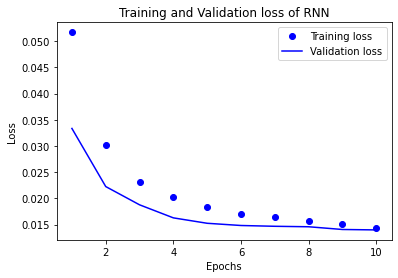

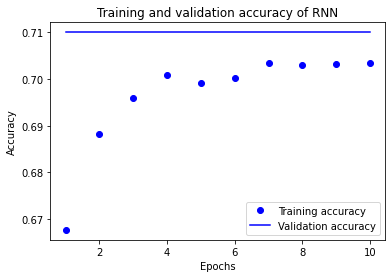

In [0]:
loss =Model.history['loss']
val_loss = Model.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss of RNN')
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = Model.history['accuracy']
val_acc = Model.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy of RNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Predicting the values on the model trained**

In [0]:
predictions = model.predict(X_test)
predictions.shape

(1200, 2)

In [0]:
# Displaying the prediction variable values
predictions

array([[0.88956624, 0.80048025],
       [0.8715183 , 0.781638  ],
       [0.90953326, 0.8235122 ],
       ...,
       [0.8973002 , 0.8099296 ],
       [0.89608955, 0.80901045],
       [0.84376425, 0.7540041 ]], dtype=float32)

# **Spearman Score calculation for the model**

 

1.   It assesses how well the relationship between two variables can be described using a monotonic function.
2.   A perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other



In [0]:
Spearman_Coefficient = scipy.stats.spearmanr(predictions, Y_test)[0]
print(Spearman_Coefficient)
print("Short-term:", Spearman_Coefficient[2][1])
print("Long-term:", Spearman_Coefficient[3][1])

[[1.         0.99992805 0.43056131 0.20752539]
 [0.99992805 1.         0.43039791 0.20711713]
 [0.43056131 0.43039791 1.         0.34074423]
 [0.20752539 0.20711713 0.34074423 1.        ]]
Short-term: 0.430397907611392
Long-term: 0.20711713473286936


# **RNN model using C3D Features**




# **Loading C3D features of the dev set**

**C3D Features**

1.   Outputs: the final classification layer of the C3D model
2.   File format: text file
3.   Feature: a single list of numbers on one line (dimension = 101)

*   A function named "read_C3D" is defined to load captions into dataframe.



In [0]:
# loading c3d feature
def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

def vname2ID(vnames):
    """Parse video digital id from its name
    vnames: a list contains file names"""
    vid = [ os.path.splitext(vn)[0]+'.webm' for vn in vnames]
    return vid

In [0]:
# load the c3d feature
C3D_Feat_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/'
# Load video related features first
# it helps with the organization of the video names
vid = labels.video.values

C3D_Features = pd.DataFrame({'video': vid,
                   'C3D': [read_C3D(C3D_Feat_path+'C3D'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })

In [0]:
# Displaying the C3D features
C3D_Features.head()

,video,C3D
0,video3.webm,"[0.02024942, 0.0015778, 0.00082625, 0.00094509..."
1,video4.webm,"[0.000118, 0.00089075, 0.00018769, 4.543e-05, ..."
2,video6.webm,"[0.01176522, 0.00074577, 0.00078353, 1.328e-05..."
3,video8.webm,"[0.00022343, 0.00016499, 7.35e-06, 1.615e-05, ..."
4,video10.webm,"[9.006e-05, 0.00061494, 0.00343634, 0.00128092..."


# **X and Y values of the prediction**

1.   C3D feature is the X variable [Captions]
2.   predictor is the Y variable [Memorability scores for short and long terms]

In [0]:
predictor = labels[['short-term_memorability', 'long-term_memorability']].values
C3D_Y = predictor
C3D_X = np.stack(C3D_Features['C3D'].values)

# **Train and Test Split**

1.   In this the dataset is splitted into the training and the test set
2.   short term and long term scores are the target values


In [0]:
C3D_X_train, C3D_X_test, C3D_Y_train, C3D_Y_test = train_test_split(C3D_X,C3D_Y, test_size=0.2, random_state=42)

In [0]:
# Displaying the shape of train and test sets
print('X_train', C3D_X_train.shape)
print('X_test', C3D_X_test.shape)
print('Y_train', C3D_Y_train.shape)
print('Y_test', C3D_Y_test.shape)

X_train (4800, 101)
X_test (1200, 101)
Y_train (4800, 2)
Y_test (1200, 2)


# **RNN model building using C3D feature**

In [0]:
# Creating Sequential Neural Network
C3D_model = Sequential()

# Adding Layers of 200 neurons
C3D_model.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(C3D_X.shape[1],)))

# Dropout layer
C3D_model.add(layers.Dropout(0.1))

# Output Layer of 2 neurons for each score
C3D_model.add(layers.Dense(2,activation='sigmoid'))

# **Compiling the RNN model**
Before training a model, compiling of the model need to be done. Arguments passed to the model are below:

1. An optimizer
2. A loss function 
3. Metrics

In [0]:
#compiling the model
C3D_model.compile(optimizer = 'adamax', loss = 'mse', metrics = ['accuracy'])

# **Training the RNN Model on C3D**

In [0]:
history=C3D_model.fit(x=C3D_X_train,y=C3D_Y_train,batch_size=50,epochs=10,validation_split=0.2,shuffle=True,verbose=True)

Train on 3840 samples, validate on 960 samples
Epoch 1/10
3840/3840 [==============================] - 0s 88us/step - loss: 0.0382 - accuracy: 0.6964 - val_loss: 0.0133 - val_accuracy: 0.6812
Epoch 2/10
3840/3840 [==============================] - 0s 71us/step - loss: 0.0135 - accuracy: 0.7091 - val_loss: 0.0132 - val_accuracy: 0.6812
Epoch 3/10
3840/3840 [==============================] - 0s 65us/step - loss: 0.0133 - accuracy: 0.7091 - val_loss: 0.0131 - val_accuracy: 0.6812
Epoch 4/10
3840/3840 [==============================] - 0s 71us/step - loss: 0.0131 - accuracy: 0.7091 - val_loss: 0.0131 - val_accuracy: 0.6812
Epoch 5/10
3840/3840 [==============================] - 0s 70us/step - loss: 0.0131 - accuracy: 0.7091 - val_loss: 0.0132 - val_accuracy: 0.6812
Epoch 6/10
3840/3840 [==============================] - 0s 67us/step - loss: 0.0131 - accuracy: 0.7091 - val_loss: 0.0132 - val_accuracy: 0.6812
Epoch 7/10
3840/3840 [==============================] - 0s 69us/step - loss: 0.0131

# **Vizualizing the model**


1.   Plotting the graph of training loss and validation loss
2.   Plotting the graph of training accuracy and validation accuracy

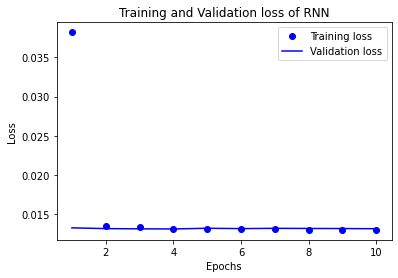

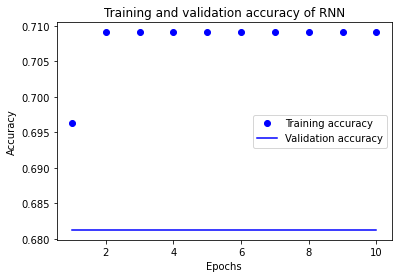

In [0]:
loss =history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss of RNN')
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy of RNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Predicting the values on the model trained**

In [0]:
C3D_Y_pred = C3D_model.predict(C3D_X_test)
C3D_Y_pred.shape

(1200, 2)

In [0]:
# Displaying the results
C3D_Y_pred

array([[0.88330024, 0.7894315 ],
       [0.840714  , 0.75976825],
       [0.8874914 , 0.8142437 ],
       ...,
       [0.8972835 , 0.8296395 ],
       [0.89709806, 0.81848305],
       [0.8782381 , 0.79364616]], dtype=float32)

# **Spearman Score calculation for the model**

In [0]:
Spearman_Coefficient = scipy.stats.spearmanr(C3D_Y_pred, C3D_Y_test)[0]
print(Spearman_Coefficient)
print("Short-term:", Spearman_Coefficient[2][1])
print("Long-term:", Spearman_Coefficient[3][1])

[[1.         0.89566684 0.27991847 0.11897203]
 [0.89566684 1.         0.24766226 0.11958639]
 [0.27991847 0.24766226 1.         0.34074423]
 [0.11897203 0.11958639 0.34074423 1.        ]]
Short-term: 0.2476622575460811
Long-term: 0.11958639106728958


# **RNN model using HMP Features**

# **Loading HMP features of the dev set**

**HMP Features**

1.   Outputs: the histogram of motion patterns for each video
2.   File format: text file
3.   Feature: a single list of pairs of numbers with format: bin:number (dimension = 6075) on one line
*   A function named "read_HMP" is defined to load captions into dataframe.

In [0]:
# loading HMP feature
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

In [0]:
# Load HMP feature from the dev set
HMP_Feat_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/'
# Load video related features first
# it helps with the organization of the video names
vid = labels.video.values
HMP_Features = pd.DataFrame({'video': vid,
                   'HMP': [read_HMP(HMP_Feat_path+'HMP'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                   })

In [0]:
# Displaying the HMP features
HMP_Features.head()

,video,HMP
0,video3.webm,"[0.125563, 0.024036, 0.000314, 0.0, 0.015864, ..."
1,video4.webm,"[0.007526, 0.001421, 6.8e-05, 0.0, 0.001184, 0..."
2,video6.webm,"[0.109584, 0.018978, 0.000289, 0.0, 0.008774, ..."
3,video8.webm,"[0.120431, 0.013561, 0.000277, 0.0, 0.018974, ..."
4,video10.webm,"[0.005026, 0.001356, 5.5e-05, 0.0, 0.000665, 2..."


# **X and Y values of the prediction**

1.   HMP feature is the X variable [Captions]
2.   predictor is the Y variable [Memorability scores for short and long terms]

In [0]:
predictor = labels[['short-term_memorability', 'long-term_memorability']].values
HMP_Y = predictor
HMP_X = np.stack(HMP_Features['HMP'].values)

# **Train and Test Split**

1.   In this the dataset is splitted into the training and the test set
2.   short term and long term scores are the target values

In [0]:
HMP_X_train, HMP_X_test, HMP_Y_train, HMP_Y_test = train_test_split(HMP_X,HMP_Y, test_size=0.2, random_state=42)

In [0]:
# Displaying the shape of train and test sets
print('X_train', HMP_X_train.shape)
print('X_test', HMP_X_test.shape)
print('Y_train', HMP_Y_train.shape)
print('Y_test', HMP_Y_test.shape)

X_train (4800, 6075)
X_test (1200, 6075)
Y_train (4800, 2)
Y_test (1200, 2)


# **RNN model building using HMP feature**

In [0]:
# Creating Sequential Neural Network
HMP_model = Sequential()

# Adding Layers of 200 neurons
HMP_model.add(layers.Dense(200,activation='relu',kernel_regularizer=None,input_shape=(HMP_X.shape[1],)))

# Dropout layer
HMP_model.add(layers.Dropout(0.1))

# Output Layer of 2 neurons for each score
HMP_model.add(layers.Dense(2,activation='sigmoid'))

# **Compiling the RNN model**

In [0]:
# Compiling the model
HMP_model.compile(optimizer = 'adamax', loss = 'mse', metrics = ['accuracy'])

# **Training the RNN Model on HMP**

In [0]:
history_HMP=HMP_model.fit(x=HMP_X_train,y=HMP_Y_train,batch_size=50,epochs=10,validation_split=0.2,shuffle=True,verbose=True)

Train on 3840 samples, validate on 960 samples
Epoch 1/10
3840/3840 [==============================] - 1s 136us/step - loss: 0.0409 - accuracy: 0.7089 - val_loss: 0.0133 - val_accuracy: 0.6812
Epoch 2/10
3840/3840 [==============================] - 0s 102us/step - loss: 0.0137 - accuracy: 0.7091 - val_loss: 0.0133 - val_accuracy: 0.6812
Epoch 3/10
3840/3840 [==============================] - 0s 103us/step - loss: 0.0137 - accuracy: 0.7091 - val_loss: 0.0133 - val_accuracy: 0.6812
Epoch 4/10
3840/3840 [==============================] - 0s 107us/step - loss: 0.0137 - accuracy: 0.7091 - val_loss: 0.0133 - val_accuracy: 0.6812
Epoch 5/10
3840/3840 [==============================] - 0s 98us/step - loss: 0.0137 - accuracy: 0.7091 - val_loss: 0.0132 - val_accuracy: 0.6812
Epoch 6/10
3840/3840 [==============================] - 0s 91us/step - loss: 0.0137 - accuracy: 0.7091 - val_loss: 0.0132 - val_accuracy: 0.6812
Epoch 7/10
3840/3840 [==============================] - 0s 93us/step - loss: 0.

# **Vizualizing the model**


1.   Plotting the graph of training loss and validation loss
2.   Plotting the graph of training accuracy and validation accuracy

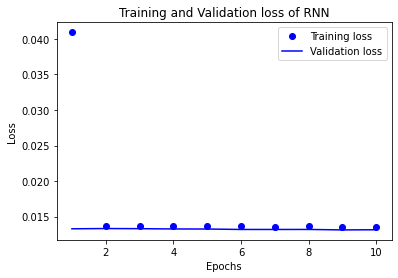

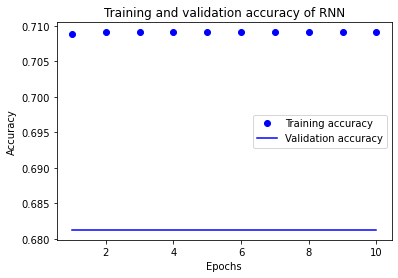

In [0]:
loss =history_HMP.history['loss']
val_loss = history_HMP.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss of RNN')
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history_HMP.history['accuracy']
val_acc = history_HMP.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy of RNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Predicting the values on the model trained**

In [0]:
HMP_Y_pred = HMP_model.predict(HMP_X_test)
HMP_Y_pred.shape

(1200, 2)

In [0]:
# Displaying the results
HMP_Y_pred

array([[0.86993694, 0.79085743],
       [0.85495013, 0.7676166 ],
       [0.8699485 , 0.7850887 ],
       ...,
       [0.8705095 , 0.7822399 ],
       [0.8669354 , 0.7787228 ],
       [0.85883665, 0.7739232 ]], dtype=float32)

# **Spearman Score calculation for the model**

In [0]:
Spearman_Coefficient = scipy.stats.spearmanr(HMP_Y_pred, C3D_Y_test)[0]
print(Spearman_Coefficient)
print("Short-term:", Spearman_Coefficient[2][1])
print("Long-term:", Spearman_Coefficient[3][1])

[[1.         0.90693787 0.25765488 0.10962696]
 [0.90693787 1.         0.23908373 0.10827604]
 [0.25765488 0.23908373 1.         0.34074423]
 [0.10962696 0.10827604 0.34074423 1.        ]]
Short-term: 0.23908373462384086
Long-term: 0.10827603758267237


# **Conclusion**

RNN trained on captions feature outperformed the RNN model trained on C3D and HMP features. The short term and long term Spearman's score for RNN with captions are respectively.

# **Training RNN with captions on the full dev dataset**

In [0]:
predictor = labels[['short-term_memorability', 'long-term_memorability']].values
Y_total = predictor
X_total = X_sequence
len(X)

6000

In [0]:
#Creating Sequential Neural Network
captions_model = Sequential()

# Embedded layer for RNN to map the data
captions_model.add(layers.Embedding(input_dim= 5191, output_dim= 20, input_length= 50, init = 'uniform'))

# Adding LSTM layer with 150 hidden neurons
captions_model.add(layers.LSTM(150, activation = 'selu', recurrent_initializer= 'uniform', kernel_initializer= 'zeros', kernel_regularizer=regularizers.l2(0.001)))
captions_model.add(layers.Dropout(0.2))

# Adding Layers of 30 neurons to map down the 150 hidden neurons
captions_model.add(layers.Dense(30, activation= 'selu', kernel_regularizer=regularizers.l2(0.001)))

# Dropout Layer
captions_model.add(layers.Dropout(0.6))

# Output Layer of 2 neurons for each score
captions_model.add(layers.Dense(2, activation= 'sigmoid'))

#Compiling the model
captions_model.compile(optimizer = 'adamax', loss = 'mse', metrics = ['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=5191, output_dim=20, input_length=50, embeddings_initializer="uniform")`
  after removing the cwd from sys.path.


In [0]:
Captions_Model = captions_model.fit(X_total, Y_total, epochs= 10)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
6000/6000 [==============================] - 34s 6ms/step - loss: 0.0462 - accuracy: 0.6687
Epoch 2/10
6000/6000 [==============================] - 34s 6ms/step - loss: 0.0256 - accuracy: 0.6930
Epoch 3/10
6000/6000 [==============================] - 33s 5ms/step - loss: 0.0205 - accuracy: 0.7013
Epoch 4/10
6000/6000 [==============================] - 32s 5ms/step - loss: 0.0186 - accuracy: 0.6995
Epoch 5/10
6000/6000 [==============================] - 32s 5ms/step - loss: 0.0171 - accuracy: 0.7017
Epoch 6/10
6000/6000 [==============================] - 33s 5ms/step - loss: 0.0162 - accuracy: 0.7025
Epoch 7/10
6000/6000 [==============================] - 32s 5ms/step - loss: 0.0154 - accuracy: 0.7033
Epoch 8/10
6000/6000 [==============================] - 33s 5ms/step - loss: 0.0147 - accuracy: 0.7045
Epoch 9/10
6000/6000 [==============================] - 33s 6ms/step - loss: 0.0141 - accuracy: 0.7047
Epoch 10/10
6000/6000 [==============================] - 32s 5ms/step - l

Now that the RNN model with captions is trained on the full dataset, lets proceed to the predictions on the test set of captions.

# **Predicting ground truth on the test set for RNN model with captions**

Since RNN with captions outperformed the other two models, so RNN with captions is used for predicting the final ground truth on the test data

In [0]:
# load the captions

Test_caps_path = '/content/drive/My Drive/CA684_Assignment/Test-set/Captions_test/test-set-1_video-captions.txt'
df_test=read_caps(Test_caps_path)

In [0]:
df_test.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


In [0]:
# Loading the ground truth
test_ground_truth=pd.read_csv('/content/drive/My Drive/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv')

In [0]:
test_ground_truth.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


# **Data Preprocessing on the test set** 

In [0]:
word_count_test = Counter()
for i, caption in enumerate(df_test['caption']):
  text = ''.join([c if c not in punctuation else ' ' for c in caption]).lower()
  df_test.loc[i, 'caption'] = text
  word_count_test.update(text.split())

In [0]:
# Displaying the caption values
df_test.head()

,video,caption
0,video7494.webm,green jeep struggling to drive over huge rocks
1,video7495.webm,hiking woman tourist is walking forward in mou...
2,video7496.webm,close up of african american doctors hands usi...
3,video7497.webm,slow motion of a man using treadmill in the gy...
4,video7498.webm,slow motion of photographer in national park


# **Text Mapping on test set**

In [0]:
length_token_test = len(word_count)
tokenizer_test = Tokenizer(num_words= length_token)
print(length_token_test)

5191


In [0]:
# Tokenizing the test set captions into integers
tokenizer_test.fit_on_texts(list(df_test.caption.values))

# **Text to word sequence on test set**

In [0]:
Test_sequences = tokenizer.texts_to_sequences(list(df_test.caption.values))

In [0]:
len(Test_sequences)

2000

In [0]:
 maximum_length = 50
X_test_sequence = np.zeros((len(Test_sequences),maximum_length))
for i in range(len(Test_sequences)):
  n = len(Test_sequences[i])
  if n == 0:
    print(i)
  else:
    X_test_sequence[i,-n:] = Test_sequences[i]

X_test_sequence.shape

(2000, 50)

In [0]:
X_testpredict = X_test_sequence
len(X_test_sequence)

2000

# **Predicting on the test set** 

In [0]:
Test_predictions = captions_model.predict(X_testpredict)

In [0]:
# Displaying the predictions
Test_predictions

array([[0.82067907, 0.731724  ],
       [0.9078254 , 0.82126325],
       [0.9289367 , 0.8478104 ],
       ...,
       [0.8845434 , 0.7949367 ],
       [0.9108317 , 0.8250873 ],
       [0.9402675 , 0.863428  ]], dtype=float32)

# **Saving the results to a .csv file**

In [0]:
# Saving the results to a csv file
prediction = pd.DataFrame(Test_predictions, columns=['Short_term_score','Long_term_score']).to_csv('/content/Results/Results.csv')


In [0]:
# Saving the model
model.save('/content/Results/RNN with captions model.h5')  # creates a HDF5 file 'RNN with captions model.h5'